# Visualizing movement models

_Tyler Coles_

To understand a movement model it's helpful to be able to visualize key components.

You can think of a movement model as a function that produces a square matrix of desired movement flux between every pair of locations in an epymorph simulation and at every point in time. That is, if we're modeling 10 places, the movement model comes up with 100 answers (10 x 10) to the question "how many people do I want to move between this place and that place, at this particular time?".

But exactly how it produces that matrix is what makes movement models interesting.

## A common pattern: dispersal kernels with a multinomial draw

As an example, I'll look at epymorph's Centroids movement model which follows a typical pattern of operation.

1. Decide how many people should leave each location -- Centroids simply says some fraction of the resident population should leave.
2. Decide on the probability which describes if a person is leaving location A, what is the chance that they wind up at B? Do this for all pairs (A,B) -- this is called the "dispersal kernel".
3. Perform a random draw process for each person who needs to move to figure out where they go -- this is a multinomial draw combining #1 and #2, and we store the result as a square matrix where the value at index [A,B] describes how many people should move from A to B.

That produces our desired movement matrix! This is implemented in the `evalute()` method (shown here with extra comments)

```python
def evaluate(self, tick: Tick) -> NDArray[np.int64]:
    # 1. how many people should leave?
    pop = self.data("population") # (N,) array
    comm_prop = self.data("commuter_proportion") # scalar in the range 0 to 1
    n_commuters = np.floor(pop * comm_prop).astype(SimDType) # (N,) array

    # 2. calculate the dispersal kernel (more on this later)
    kernel = self.dispersal_kernel # (N,N) array

    # 3. random draw
    return self.rng.multinomial(n_commuters, kernel) # (N,N) array
    # This shape works out because multinomial is a "vectorized" operation:
    # Essentially the same as combining the first value from n_commuters
    # with the first (N,)-shaped row of the kernel, and so on.
    # In that way we sort n_commuters into the "buckets" described by kernel,
    # those buckets represent destinations, so we've successfully sorted all
    # movers into their destination.
```

## So what's up with the dispersal kernel?

The above code doesn't show _how_ the dispersal kernel is calculated. We'll focus in on this question for the rest of this document. It turns out we can express a lot of variability between models just by coming up different ways to calculate the kernel. You can also think of the kernel as describing (in relative terms) how "connected" two places are. And then we make an assumption that the more connected two places are, the more likely a randomly-selected commuter would be traveling between those two places. If (Phoenix,Los Angeles) has a "connectedness score" of 0.5 and (Phoenix,New York) has a score of 0.25 -- I would say that someone leaving Phoenix is twice as likely to go to LA as they are to go to New York. It's a simple mechanism, but a useful one.

The Centroids movement model calculates its dispersal kernel primarily based on the distance between the geographic centroids. Take for example US counties; the border of a county on a flat map is a polygon, and each polygon has a center. (You may want -- for various reasons -- to choose something other than the exact geometric centroid, regardless, all that matters is we can identify _some_ point for every US county.)

If I have the centroids for every county in my simulation, I can calculate the distance between every pair of counties [using the haversine equation](https://en.wikipedia.org/wiki/Haversine_formula), producing an (N,N) array.

I then run every distance in that matrix through a function to covert it to our "connectedness score" result. For Centroids, that function is:

$$\frac{1}{e^{distance / \phi}}$$

Where $\phi$ is a constant parameter which lets us tune the results.

Note that this function doesn't change over time (nor do we expect our centroids to move around!) so we can compute the kernel once at the start of the simulation.

Let's plot this function as distance increases.

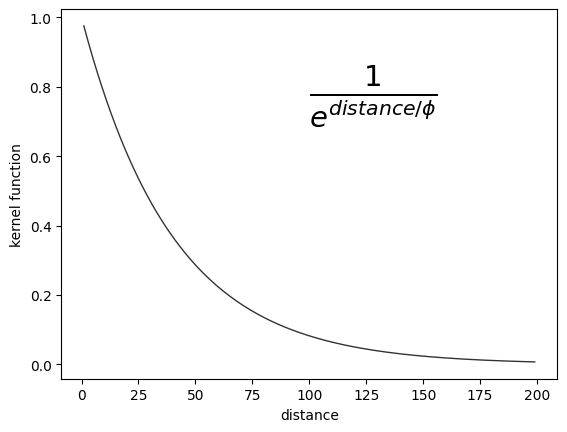

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
xs = np.arange(1, 200)
ys = 1 / np.exp(xs / 40.0)
ax.plot(xs, ys, color="black", linewidth=1, alpha=0.8)
ax.set_xlabel("distance")
ax.set_ylabel("kernel function")
ax.text(100, 0.75, "$\\frac{1}{e^{distance / \\phi}}$", fontsize=30)
plt.show()

And let's see how this works when applied to some real centroids.

In [2]:
from epymorph import *
from epymorph.adrio import us_tiger
from epymorph.geography.us_census import CountyScope
from epymorph.util import pairwise_haversine

# Create a scope
scope = CountyScope.in_states(["AZ", "NM", "CO", "UT"], year=2020)
print(f"{scope.nodes=}")

# And get centroids for all the locations using an ADRIO
centroids = us_tiger.InternalPoint().with_context(scope=scope).evaluate()  # (N,) array

# This is copied with some minor changes from Centroids' dispersal_kernel function
phi = 40.0
distance = pairwise_haversine(
    centroids["longitude"],
    centroids["latitude"],
)  # (N,N) array
kernel = 1 / np.exp(distance / phi)

# the diagonal of this matrix represents movement from location A to location A,
# which isn't useful for us, so we zero it out
np.fill_diagonal(kernel, 0)

# I'm omitting row_normalize() because I want to look at the values
# exactly as they are produced by our kernel function.
# The only reason we row_normalize() is because the multinomial draw
# wants its probability values to be normalized.

np.set_printoptions(formatter={"float": lambda x: f"{x:.5f}"})
print(f"{kernel.shape=}")

# Look at a few values...
print(f"kernel[:4,:4]=\n{kernel[:4,:4]}")

scope.nodes=141
kernel.shape=(141, 141)
kernel[:4,:4]=
[[0.00000 0.00216 0.03694 0.03556]
 [0.00216 0.00000 0.00057 0.02499]
 [0.03694 0.00057 0.00000 0.02283]
 [0.03556 0.02499 0.02283 0.00000]]


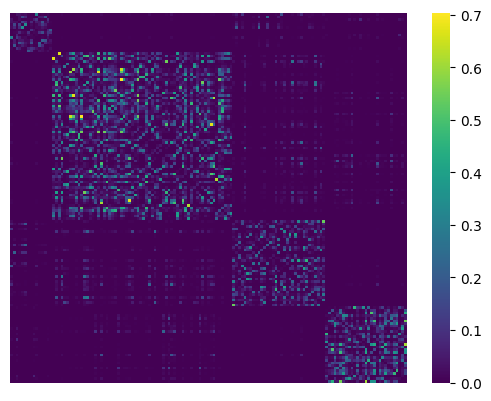

In [3]:
import seaborn as sns

# Plot the kernel as a heatmap
fig, ax = plt.subplots()
sns.heatmap(
    kernel,
    cmap="viridis",
    ax=ax,
)
ax.set_axis_off()
plt.show()

# See how there are four clear "squares" evident in the data?
# Those align with the four states in our scope!
# (The natural ordering of counties in a scope cause them to get grouped by state.)
# The counties within a state are generally closer to the other
# counties in that state and farther from counties of other states,
# so we get this visible pattern.

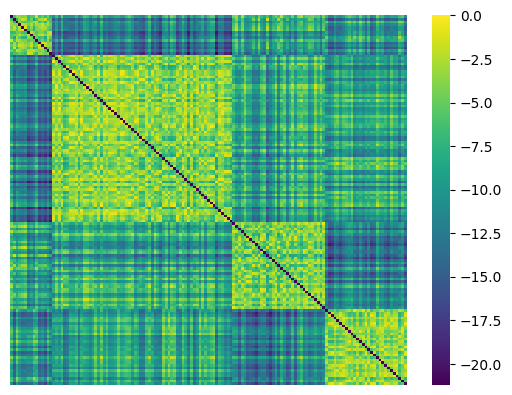

In [4]:
# Plot the kernel in log scale

# Copy the kernel and add floating-point epsilon (to avoid log(0) errors)
log_kernel = np.log(kernel.copy() + np.finfo(np.float64).eps)

# Find min value ignoring diagonal
mask = np.ones_like(log_kernel, dtype=bool)
np.fill_diagonal(mask, 0)
vmin = log_kernel[mask].min()

fig, ax = plt.subplots()
sns.heatmap(
    log_kernel,
    cmap="viridis",
    vmax=0,
    vmin=vmin,
    ax=ax,
)
ax.set_axis_off()
plt.show()

And if we want to double-check that we correctly calculated the dispersal kernel, if we plot distance on the x-axis and kernel values on the y-axis, the values should all lie along the function's line we plotted earlier.

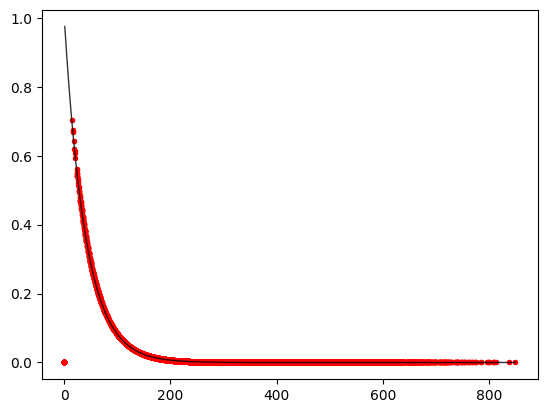

In [5]:
fig, ax = plt.subplots()

# Plot our calculated values as red dots
ax.scatter(distance, kernel, s=8, color="red")

# Re-plot the function line as a black line
xs = np.arange(1, 850)
ys = 1 / np.exp(xs / phi)
ax.plot(xs, ys, color="black", linewidth=1, alpha=0.8)

plt.show()

# Success!
# Notice there are also some dots at (0,0) -- these are the diagonals we zero'd out.

Given any row from our distance kernel, we could also plot the kernel values on a choropleth map. (I like to map the kernel in log scale because it's a bit easier to see the patterns.)

In [6]:
from epymorph.geography.us_tiger import get_counties_geo
import geopandas as gpd

# Get a GeoDataFrame for counties
gdf = get_counties_geo(2020)
# And filter for the counties that are in our scope
gdf = gpd.GeoDataFrame(gdf[gdf["GEOID"].isin(scope.node_ids)])
gdf = gdf.sort_values(by="GEOID")

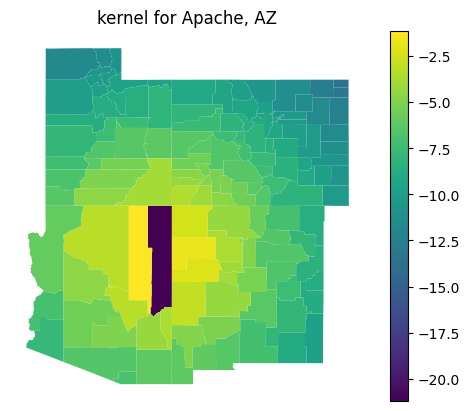

In [7]:
# Add a column for the kernel values for Apache County, Arizona (node 0)
gdf["data"] = log_kernel[0, :]

# Draw our GeoDataFrame with data column
fig, ax = plt.subplots()
gdf.plot(ax=ax, column="data", legend=True, vmin=vmin)
ax.axis("off")
plt.title("kernel for Apache, AZ")
plt.show()

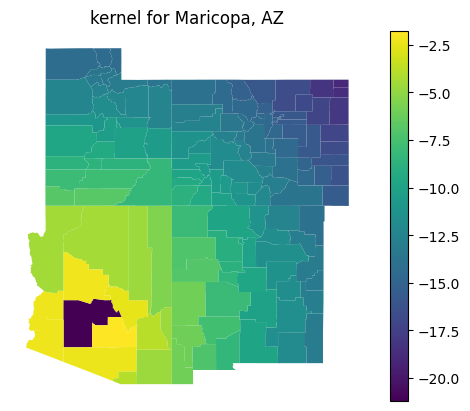

In [8]:
# Plot kernel values for Maricopa County, Arizona (node 7)
gdf["data"] = log_kernel[7, :]

fig, ax = plt.subplots()
gdf.plot(ax=ax, column="data", legend=True, vmin=vmin)
ax.axis("off")
plt.title("kernel for Maricopa, AZ")
plt.show()

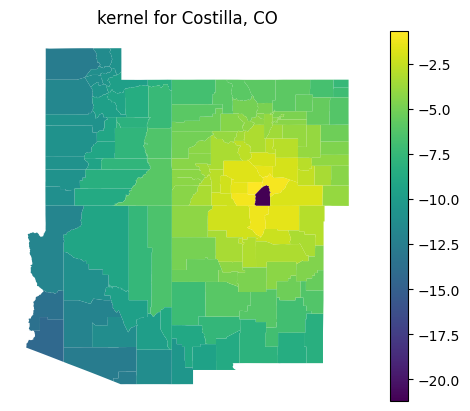

In [9]:
# Plot kernel values for Costilla County, Colorado (node 27)
gdf["data"] = log_kernel[27, :]

fig, ax = plt.subplots()
gdf.plot(ax=ax, column="data", legend=True, vmin=vmin)
ax.axis("off")
plt.title("kernel for Costilla, CO")
plt.show()

We can see a clear pattern emerging -- our movement model shows higher probabilities of movement when two locations are close to one another, and lower probabilities of movement when two locations are far apart. Exactly as designed!